In [4]:
# Set directory to store-sales-time-series-forecasting
import os
import gc
import pandas as pd
import numpy as np


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import plotly.express as px


import seaborn as sns

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#os.chdir('./store-sales-time-series-forecasting')


In [2]:
import statsmodels
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import plotly.graph_objs as go


In [5]:
#import train and test data
train = pd.read_csv('train.csv', index_col=['date'], parse_dates=['date'])
test = pd.read_csv('test.csv')

#import stores data
stores = pd.read_csv('stores.csv')

#import holidays data
holidays = pd.read_csv('holidays_events.csv', index_col=['date'], parse_dates=['date'])

#import oil data
oil = pd.read_csv('oil.csv')

#import transactions data
transactions = pd.read_csv('transactions.csv', index_col=['date'], parse_dates=['date'])

train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [52]:
# Define a function which will predict all future values to be the final value of inputed dataset
def predict_last_value(df):
    last_value = df.iloc[-1]
    return np.repeat(last_value, len(df))

predict_last_value(train.sales)


array([16., 16., 16., ..., 16., 16., 16.], dtype=float32)

In [18]:
# Group train by date and sum the sales
train_date = train.groupby('date').sum()

In [21]:
from statsmodels.tsa.arima_model import ARIMA

arima = sm.tsa.arima.ARIMA(train_date.sales, order=(1, 1, 1))  

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
arima_fit = arima.fit()


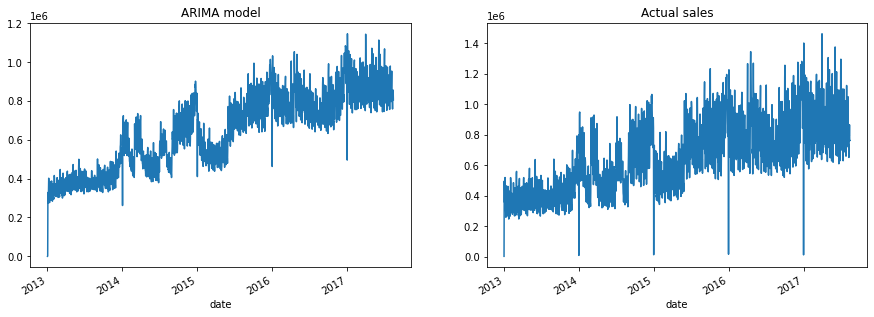

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
arima_fit.predict().plot(ax=ax[0])
train_date.sales.plot(ax=ax[1])
# Add title to first graph
ax[0].set_title('ARIMA model')
# Add title to second graph
ax[1].set_title('Actual sales')
plt.show()


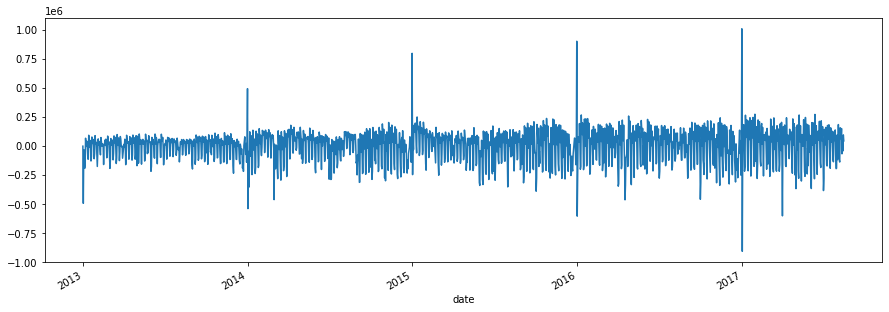

In [33]:
# Show the difference between arima_fit.predict() and train_date.sales
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
(arima_fit.predict() - train_date.sales).plot(ax=ax)
plt.show()

In [54]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result
    
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

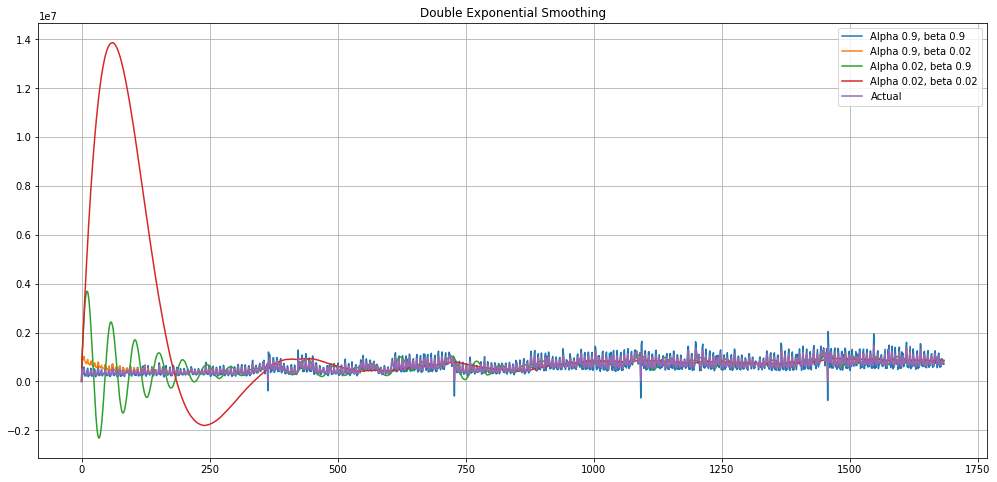

In [55]:
plot_double_exponential_smoothing(train_date.sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [56]:
smoothing = double_exponential_smoothing(train_date.sales, 0.9 , 0.9)

In [61]:
# Get the mean percentage error of predict_last_value and train_date.sales
mean_absolute_percentage_error(predict_last_value(train_date.sales)[predict_last_value(train_date.sales) != 0], train_date.sales[train_date.sales != 0])

28.893321752548218

In [62]:
# Get the mean percentage error of arima_fit.predict() and train_date.sales
mean_absolute_percentage_error(arima_fit.predict()[arima_fit.predict() != 0], train_date.sales[train_date.sales != 0])

32.868376089766656

In [63]:
# Get the mean percentage error of smoothing and train_date.sales
mean_absolute_percentage_error(smoothing[smoothing != 0], train_date.sales[train_date.sales != 0])

37.56130933761597